In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Festlegung der Dimensionen
n = 12
m = 100

# Wuerfeln der Standorte (Koordinaten)
x = np.random.randint(1, m+1, n)
y = np.random.randint(1, m+1, n)
Koord = np.column_stack((x, y))

# Bestimmung der Entfernungsmatrix
Entfernungsmatrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        Entfernungsmatrix[i, j] = np.linalg.norm(Koord[i] - Koord[j])



Zufaellige Ablauffolge: 6 7 2 4 10 0 9 1 11 8 3 5
Summe der Entfernungen: 854.1462543980177 



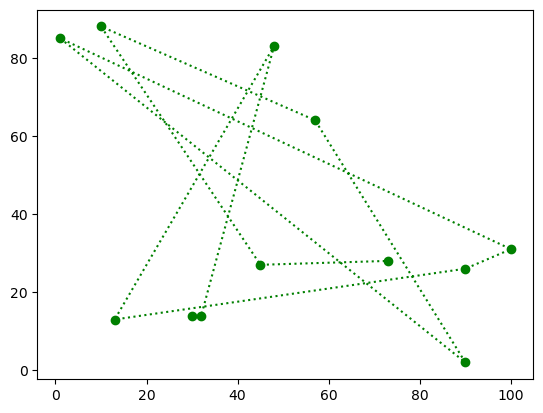

In [7]:
# Beliebiges Durchlaufen der Standorte
Folge = np.random.permutation(n)

# Berechnung der zurückgelegten Entfernung
Entf = Entfernungsmatrix[Folge[n-1], Folge[0]]
for i in range(n-1):
    Entf += Entfernungsmatrix[Folge[i], Folge[i+1]]

# Graphische Darstellung der Route
xx = np.concatenate((x[Folge], [x[Folge[0]]]))
yy = np.concatenate((y[Folge], [y[Folge[0]]]))
# plot the points and the path between them, use a dashed line and circle markers
plt.plot(x, y, ':o', color='green')

# Ausgabe der Informationen
print('\nZufaellige Ablauffolge:', ' '.join(map(str, Folge)))
print('Summe der Entfernungen:', Entf, '\n')

# Speicherung der Daten für die nachfolgende Optimierung
np.savez('Entfernungsmatrix.npz', Entfernungsmatrix=Entfernungsmatrix, Koord=Koord)
